<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>End-to-End time-series regression modeling using statsmodels<span class="tocSkip"></span></h1> 

This notebook walks you through a standard process for building a time-series econometric model:
1. Data transformation
2. Data exploration (incl. unit root / stationarity testing)
3. Single factor regression (OLS, Fractional Logit; eventually can be extended easily to GLM)
4. Standard variable selection & Multi-factor regression
Separate notebook form model testing on candidate model

This notebook relies on re-usable functions, which you can modify or extend as you see fit.

Quick note about statsmodels: It uses two types of syntax: one that is formula based (similar to R) and one that is is similar to sklearn. We will use the latter, as it enables further integration and use of sklearn's foundational capabilities (e.g. cross-validation, model pipelining, etc.) in a future notebook.

For guidance on modeling best practices, see the Playbook for timeseries modeling at the bottom of: https://owlabs.atlassian.net/wiki/spaces/SQUADGAIA/overview

<h2>User Guidance<span class="tocSkip"></span></h2>

To use this notebook, you need to have a unified input Excel with historical data and scenario data. This would be used as the starting point for a ‘Session’.

a.	This Excel is copied into a new Excel file named with the session name specified in section 2.

b.	Every interim output / input is sent to this Excel, including

- variable mapping table (section 4)

- variable short list for MFA tests (section 8.1)

- selected models with 2 variables for alternative MFA runs (mannual list) (section 8.3.2)

c.	All outputs are generated into this Excel, including

- data after transformation (section 4)

- unit root testing results (section 5)

- SFA results (section 7)

- MFA best subsets results (section 8.4.1)

- top models with 2 variables for alternative MFA runs (mannual list) (section 8.3.2)

- MFA mannual list results (section 8.4.2)
    
All plots will be saved in a seperate folder named "plots_for_{session name}" appended by the session name.

Note: If you wish to upload a session and continue from there, skip the export parts for the results that are already in your session.

<h2>Contents<span class="tocSkip"></span></h2>

<ul class="toc-item"><li><span><a href="#Import-key-libraries" data-toc-modified-id="Import-key-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import key libraries</a></span></li><li><span><a href="#Start-new-session" data-toc-modified-id="Start-new-session-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Start new session</a></span></li><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load dataset</a></span><ul class="toc-item"><li><span><a href="#Create-timestamped-row-index" data-toc-modified-id="Create-timestamped-row-index-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create timestamped row index</a></span></li><li><span><a href="#Explore-the-dataset" data-toc-modified-id="Explore-the-dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explore the dataset</a></span></li><li><span><a href="#Target-variable-time-series-plot" data-toc-modified-id="Target-variable-time-series-plot-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Target variable time-series plot</a></span></li><li><span><a href="#Generate-plots-for-all-variables" data-toc-modified-id="Generate-plots-for-all-variables-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Generate plots for all variables</a></span></li></ul></li><li><span><a href="#Variable-transformations" data-toc-modified-id="Variable-transformations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variable transformations</a></span></li><li><span><a href="#Unit-root-/-stationarity-testing" data-toc-modified-id="Unit-root-/-stationarity-testing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Unit root / stationarity testing</a></span></li><li><span><a href="#Model-settings" data-toc-modified-id="Model-settings-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model settings</a></span></li><li><span><a href="#SFA" data-toc-modified-id="SFA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SFA</a></span></li><li><span><a href="#MFA-with-variable-selection" data-toc-modified-id="MFA-with-variable-selection-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>MFA with variable selection</a></span><ul class="toc-item"><li><span><a href="#Variable-Short-List" data-toc-modified-id="Variable-Short-List-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Variable Short List</a></span></li><li><span><a href="#Example-of-using-best-subsets-in-R-for-variable-selection" data-toc-modified-id="Example-of-using-best-subsets-in-R-for-variable-selection-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Example of using best subsets in R for variable selection</a></span></li><li><span><a href="#Alternative-variable-selection-through-all-relevant-combinations-of-models" data-toc-modified-id="Alternative-variable-selection-through-all-relevant-combinations-of-models-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Alternative variable selection through all relevant combinations of models</a></span><ul class="toc-item"><li><span><a href="#Two-variable-models" data-toc-modified-id="Two-variable-models-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>Two-variable models</a></span></li><li><span><a href="#Short-list-top-2-variable-models,-for-which-to-search-for-incremental-variable" data-toc-modified-id="Short-list-top-2-variable-models,-for-which-to-search-for-incremental-variable-8.3.2"><span class="toc-item-num">8.3.2&nbsp;&nbsp;</span>Short list top 2 variable models, for which to search for incremental variable</a></span></li><li><span><a href="#Generate-all-incremental-variables" data-toc-modified-id="Generate-all-incremental-variables-8.3.3"><span class="toc-item-num">8.3.3&nbsp;&nbsp;</span>Generate all incremental variables</a></span></li></ul></li><li><span><a href="#Perform-MFA-regression-on-long-candidate-model-list" data-toc-modified-id="Perform-MFA-regression-on-long-candidate-model-list-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Perform MFA regression on long candidate model list</a></span><ul class="toc-item"><li><span><a href="#List-from-best-subsets" data-toc-modified-id="List-from-best-subsets-8.4.1"><span class="toc-item-num">8.4.1&nbsp;&nbsp;</span>List from best subsets</a></span></li><li><span><a href="#Manual-list" data-toc-modified-id="Manual-list-8.4.2"><span class="toc-item-num">8.4.2&nbsp;&nbsp;</span>Manual list</a></span></li></ul></li></ul></li><li><span><a href="#Notes" data-toc-modified-id="Notes-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Notes</a></span></li></ul>

# Import key libraries

In [1]:
# Import key libraries
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from openpyxl import load_workbook
import shutil 
import os

%load_ext autoreload
%autoreload 2

**Import code stored in the utilities folder**

In [2]:
import sys
sys.path.insert(0, "../../utilities")

from data_exploration import timeseries_plots, unit_root_testing
from data_transformations import timeseries_transforms
from regression import sfa_ols, mfa_ols

# Start new session

In [4]:
# Name your session here
session_name="Test Session"

**Specify input file and output folder**

The output will be named "{session_name}_{input_name}"

In [29]:
input_file = 'sample_input/ts_model_data.xlsx'
output_folder = 'sample_output'

used_filepath = f'{output_folder}/{session_name}_{os.path.basename(input_file)}'

# Duplicate the Excel file by copying it to the new destination path with the appended file name
shutil.copyfile(input_file, used_filepath)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_input/ts_model_data.xlsx'

# Load dataset

The historical data should be located in the 'input_dataset' tab of the Excel file.

In [6]:
# Define DV
DV= 'myDepVar'

# Read in the data using pandas
dataset = pd.read_excel(used_filepath, sheet_name='input_dataset')
dataset.head(1)

,date_quarter,myDepVar,real_gdp_iusa,nom_gdp_iusa,avg_hrlyearningsmgf_iusa,bankrupt_totalbus_iusa,pers_consumpexp_iusa,cap_index_iusa,pers_consumpdurables_iusa,cap_util_iusa,...,tbond_10yr_iusa,tbond_2yr_iusa,libor_3m_iusa,sofr_iusa,retail_sales_tot_iusa,corporate_cash_flow_iusa,per_cap_dis_pers_inc_qtr_iusa,corp_profit_inv_valuation_iusa,corp_profit_iva_iusa,unemploy_iusa
0,2000Q1,3.0572,12935.252,10002.179,14.146667,38109.0,6618.217,114.965067,920.875,80.372733,...,6.468413,6.526349,6.115781,5.627302,2961.576,983.735,33208.0,808.499,565.189,4.033333


## Create timestamped row index

One of the columns in the dataset needs to contain the timestamp, and it should be converted into a datetime and set to the index. 

You can use the pd.PeriodIndex in cases when the column in the input dataset is:
* Quarterly, e.g. 2004Q1, 2004Q2, use freq='Q'
* Annual, e.g. 2004, 2005, use freq='Y'
* Monthly, e.g. 2004-1, 2004-2, 2004-3, use freq='M'

You can of course customize the code for the index as you see fit

In [7]:
dataset.index = pd.PeriodIndex(dataset['date_quarter'], freq='Q').to_timestamp()

In [8]:
# Name the index
dataset.index.name = 'date' # Name of the index (do not change)
dataset = dataset.sort_values(by='date', ascending=True) # Sort the dataset in descending order of date
dataset.head()

,date_quarter,myDepVar,real_gdp_iusa,nom_gdp_iusa,avg_hrlyearningsmgf_iusa,bankrupt_totalbus_iusa,pers_consumpexp_iusa,cap_index_iusa,pers_consumpdurables_iusa,cap_util_iusa,...,tbond_10yr_iusa,tbond_2yr_iusa,libor_3m_iusa,sofr_iusa,retail_sales_tot_iusa,corporate_cash_flow_iusa,per_cap_dis_pers_inc_qtr_iusa,corp_profit_inv_valuation_iusa,corp_profit_iva_iusa,unemploy_iusa
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000Q1,3.057200,12935.252,10002.179,14.146667,38109.0,6618.217,114.965067,920.875,80.372733,...,6.468413,6.526349,6.115781,5.627302,2961.576,983.735,33208.0,808.499,565.189,4.033333
2000-04-01,2000Q2,3.156433,13170.749,10247.720,14.253333,36910.0,6711.911,116.466500,901.931,80.385800,...,6.184921,6.572698,6.632572,6.085397,2960.768,980.236,33521.0,798.135,556.425,3.933333
2000-07-01,2000Q3,3.162594,13183.890,10318.165,14.363333,36065.0,6819.984,117.966433,911.658,79.337133,...,5.889841,6.216984,6.699063,6.428730,2986.356,989.391,33863.0,781.208,558.414,4.000000
2000-10-01,2000Q4,1.930616,13262.250,10435.744,14.503333,35472.0,6918.606,119.461400,915.823,77.909633,...,5.570645,5.719032,6.698721,6.440323,3008.840,972.691,33983.0,758.394,532.415,3.900000
2001-01-01,2001Q1,2.852916,13219.251,10470.231,14.536667,35992.0,6995.298,120.905467,926.811,75.966733,...,5.044194,4.580161,5.336416,5.509516,3022.744,1026.453,34182.0,747.995,559.398,4.233333


## Explore the dataset
**This uses the data exploration code, which should be automatically downloaded and available if you are using the Gryphon tool** 

In [9]:
from data_exploration import dataset_overview

In [10]:
num_info = dataset_overview.get_numerical_info(dataset)

,myDepVar,real_gdp_iusa,nom_gdp_iusa,avg_hrlyearningsmgf_iusa,bankrupt_totalbus_iusa,pers_consumpexp_iusa,cap_index_iusa,pers_consumpdurables_iusa,cap_util_iusa,indust_prod_iusa,...,tbond_10yr_iusa,tbond_2yr_iusa,libor_3m_iusa,sofr_iusa,retail_sales_tot_iusa,corporate_cash_flow_iusa,per_cap_dis_pers_inc_qtr_iusa,corp_profit_inv_valuation_iusa,corp_profit_iva_iusa,unemploy_iusa
data type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
count,93,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
# non-missing,93,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
# missing,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
# of 0s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
# unique values,93,94,94,93,93,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,72
sum,269.319677,1540963.28589,1555123.51818,1791.72,3049515.08372,1052327.05271,12094.057216,121169.574167,7096.552811,9109.598349,...,302.968282,192.697795,187.90153,156.637557,417235.622626,181734.963268,3753118.11793,168598.712573,138841.898483,546.0
mean,2.895911,16393.226446,16543.867215,19.060851,32441.649827,11194.968646,128.660183,1289.038023,75.495243,96.910621,...,3.223067,2.049977,1.998952,1.666357,4438.676836,1933.350673,39926.788489,1793.603325,1477.041473,5.808511
standard deviation,0.722932,2074.5405,4359.02172,3.015149,11939.488577,2989.625424,3.993781,352.571308,3.496324,4.93567,...,1.312933,1.71938,1.914762,1.876266,1125.786837,558.803686,4218.490127,605.974,545.616351,1.961554
skewness,0.376236,0.195138,0.496635,0.42671,0.592628,0.493503,-1.006285,1.507844,-1.381069,-0.504377,...,0.238003,0.8415,0.988633,1.085329,0.909235,0.199474,0.621548,0.013877,0.070737,1.13308


In [11]:
cat_info = dataset_overview.get_non_numerical_info(dataset)

,date_quarter
data type,object
count,94
# non-missing,94
# missing,0
# of blanks,0
# unique values,94
most frequent,2000Q1
average length,6.0
potentially numeric,No
potentially datetime,Yes


## Target variable time-series plot

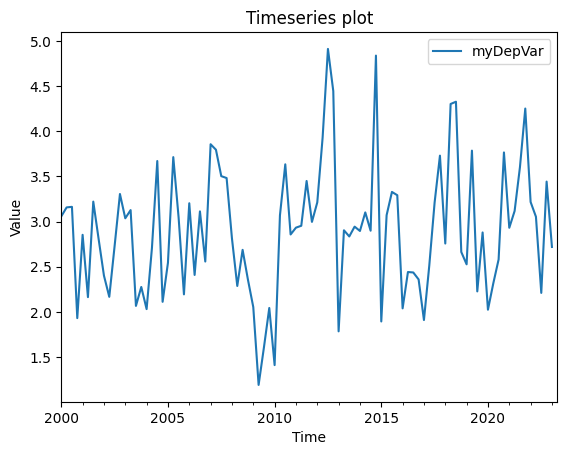

<Axes: title={'center': 'Timeseries plot'}, xlabel='Time', ylabel='Value'>

In [12]:
timeseries_plots.plot_ts(data=dataset, timestamp=None, variables=[DV],save_dir = f"{output_folder}/plots_for_{session_name}")

**You can use help(timeseries_plots.plot_ts) to learn more**

In [13]:
help(timeseries_plots.plot_ts)

Help on function plot_ts in module data_exploration.timeseries_plots:

plot_ts(data, timestamp=None, variables=None, plot_title='Timeseries plot', use_grid=False, save_dir='plots', **kwargs)
    This function plots a timeseries from a pandas DataFrame using matplotlib. 
    
    Parameters:
    data (pandas.DataFrame): The DataFrame containing the data to be plotted.
    timestamp (str, optional): The column name in the DataFrame that contains the timestamp. If None, the DataFrame's index is used. Default is None.
    variables (str or list of str): The column name(s) in the DataFrame that contain the variables to be plotted. If a string is provided, it is converted to a list.
    plot_title (str, optional): The title of the plot. Default is 'Timeseries plot'.
    use_grid (bool, optional): If True, a grid is added to the plot. Default is False.
    **kwargs: Additional keyword arguments to be passed to the pandas.DataFrame.plot() function.
    
    Raises:
    ValueError: If the 'vari

## Generate plots for all variables

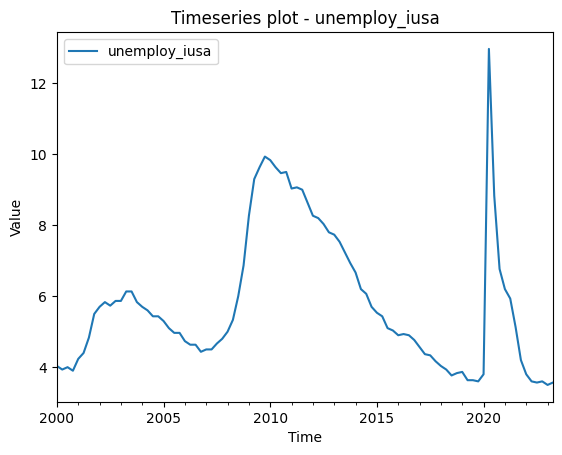

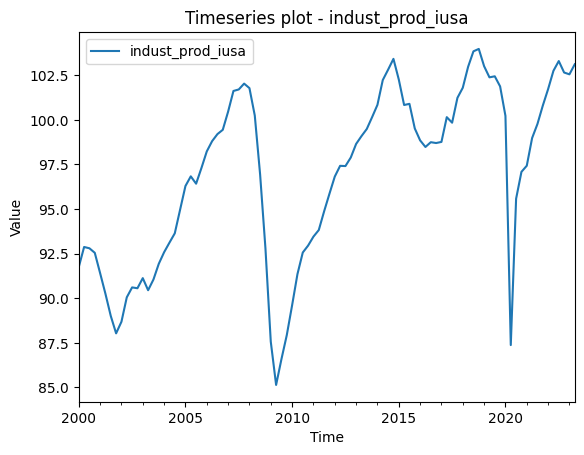

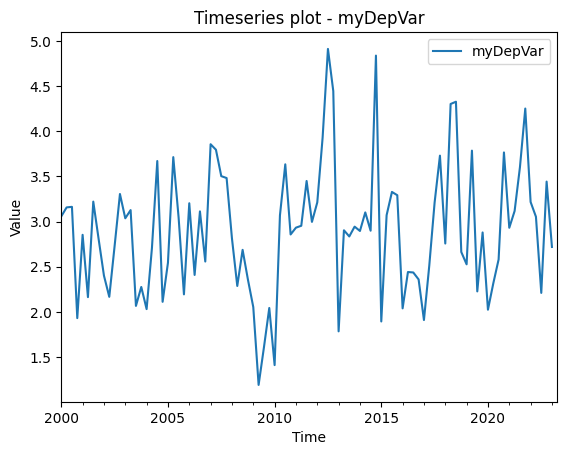

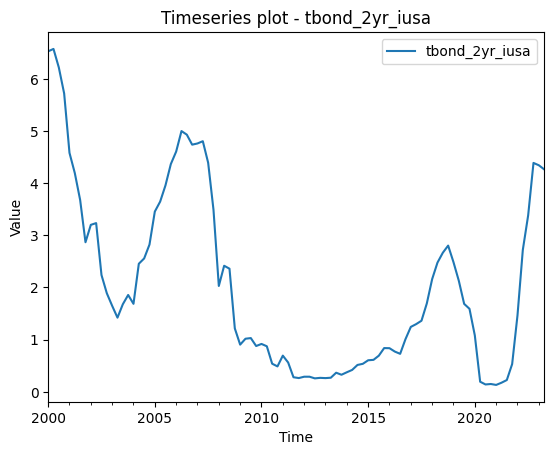

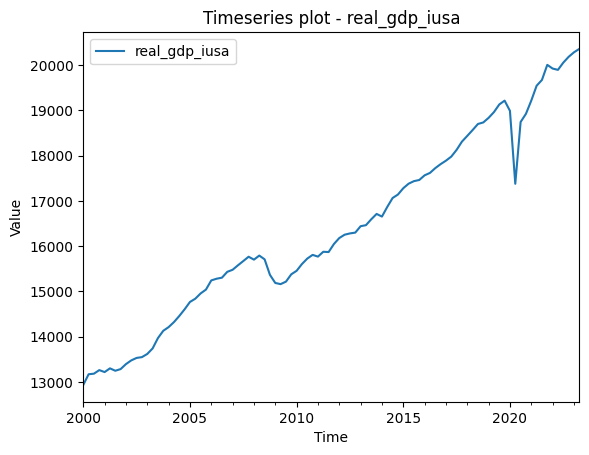

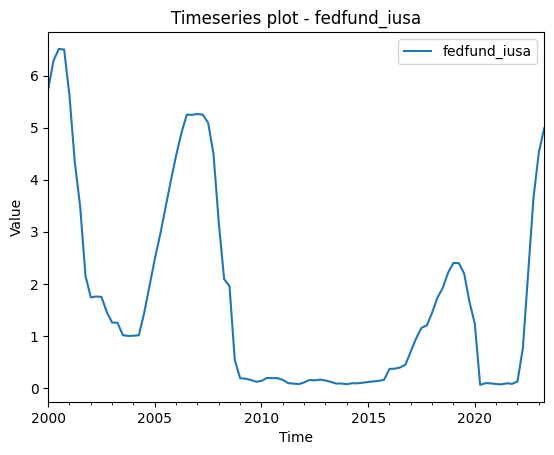

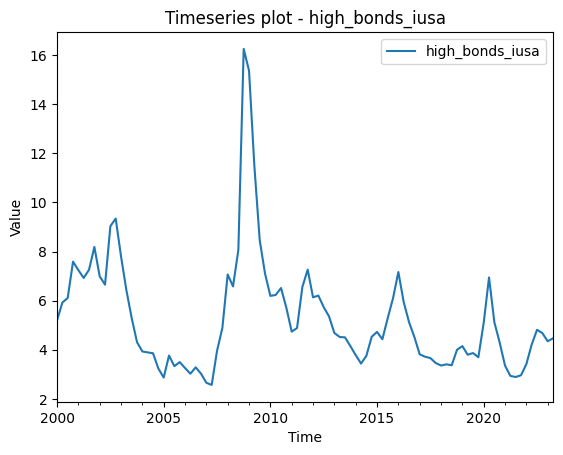

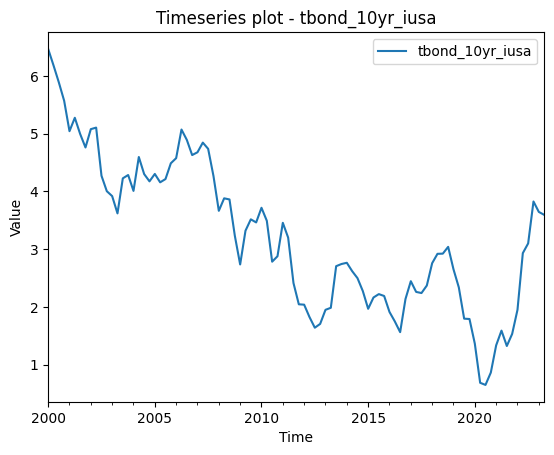

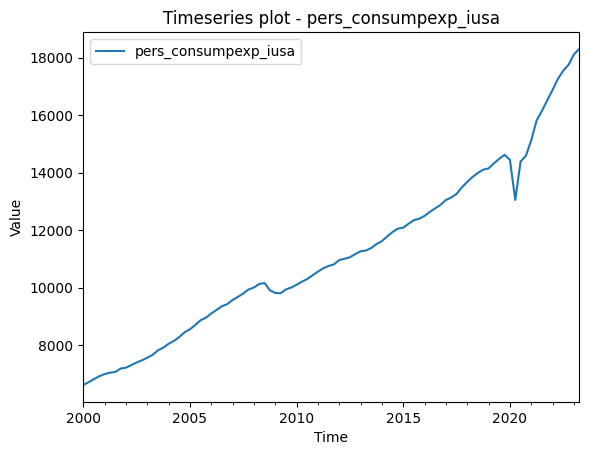

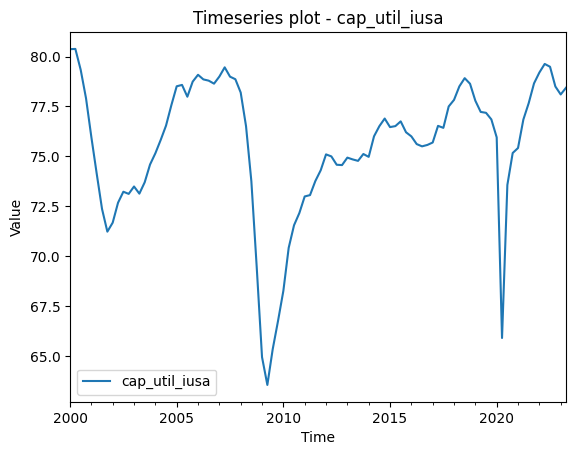

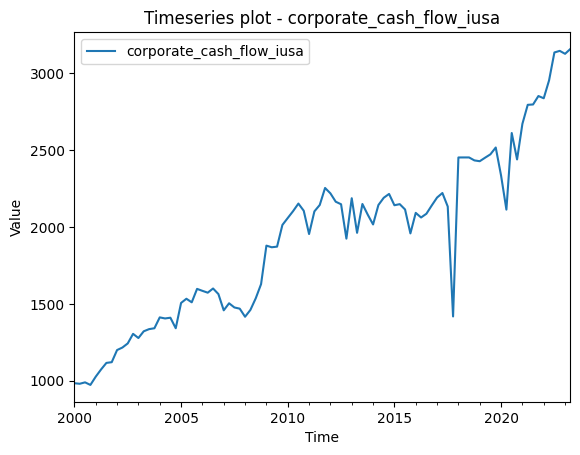

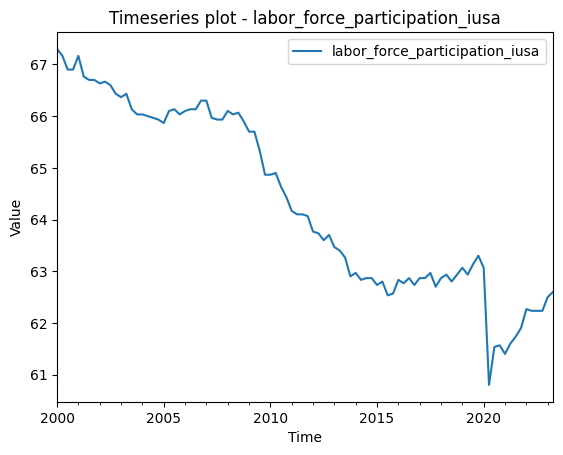

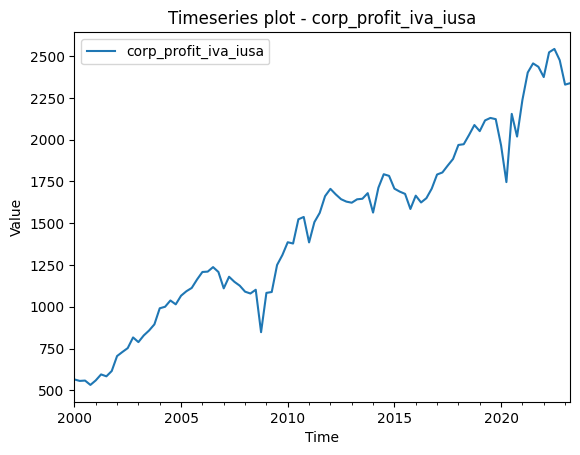

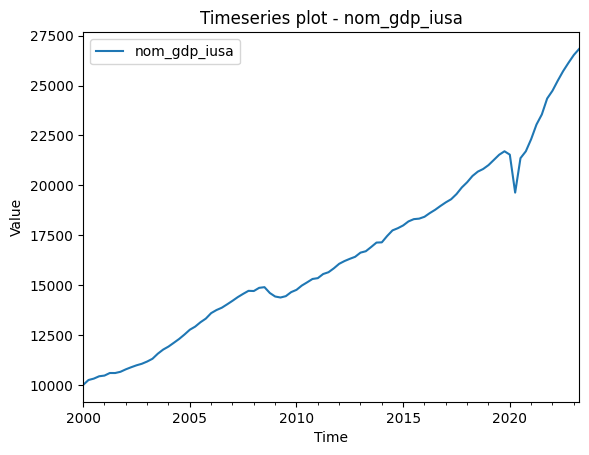

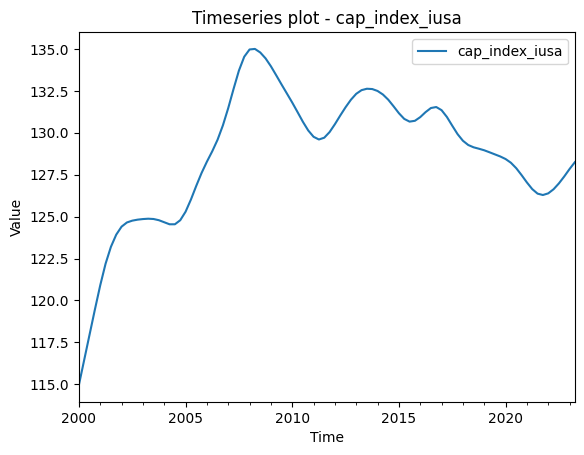

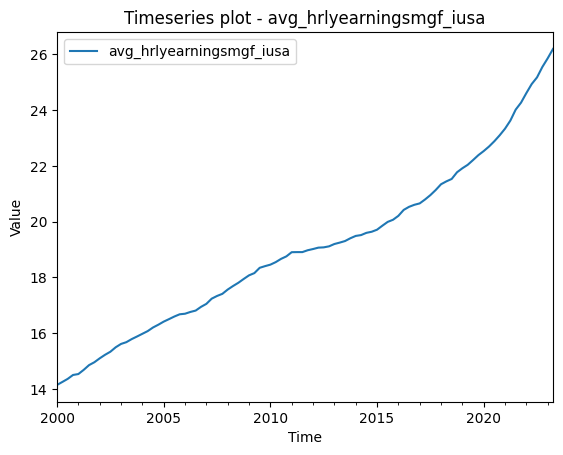

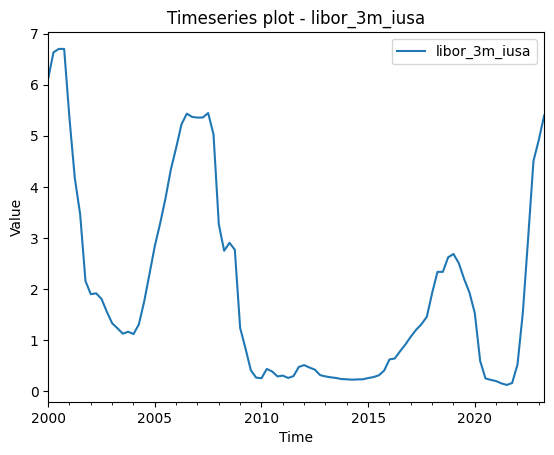

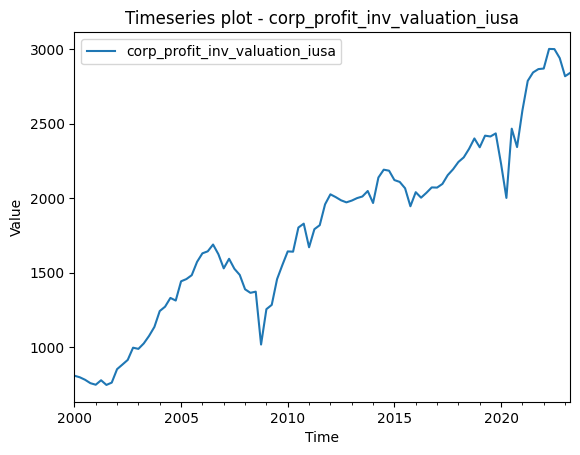

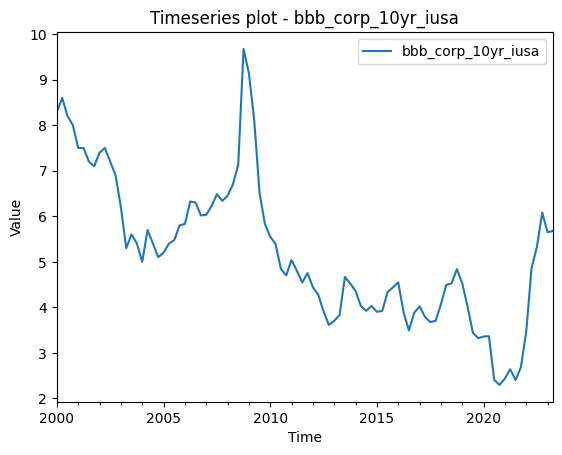

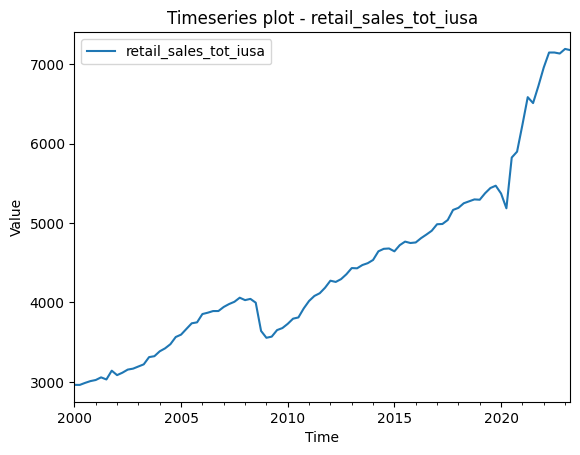

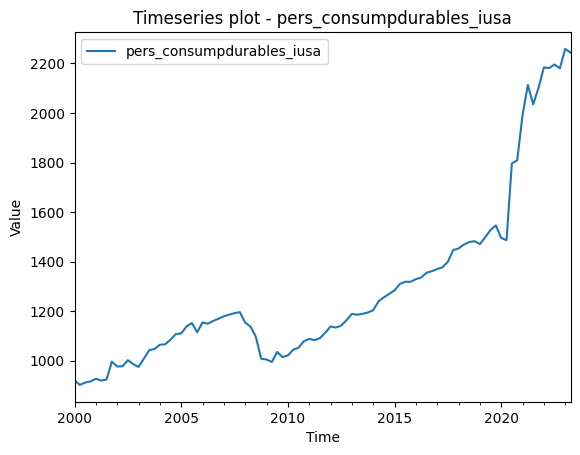

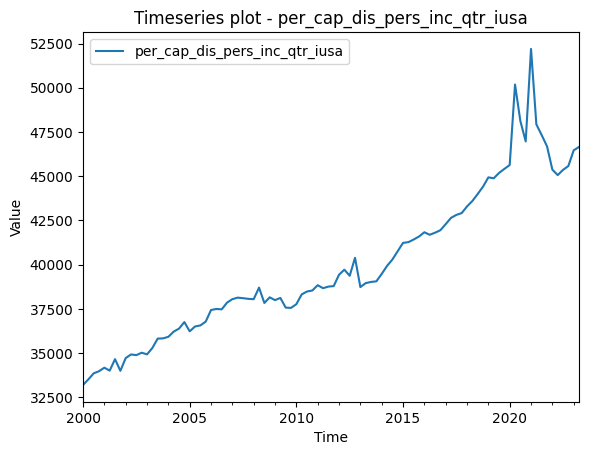

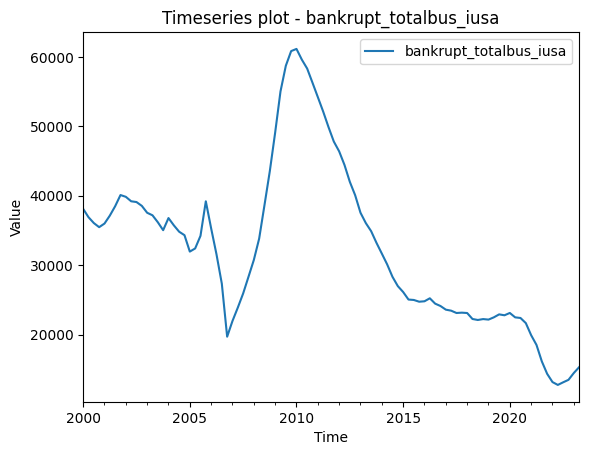

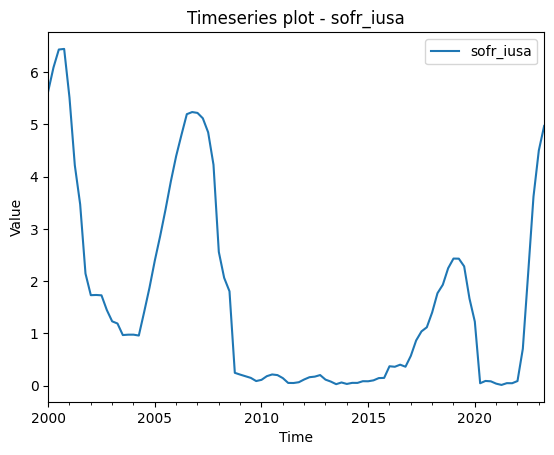

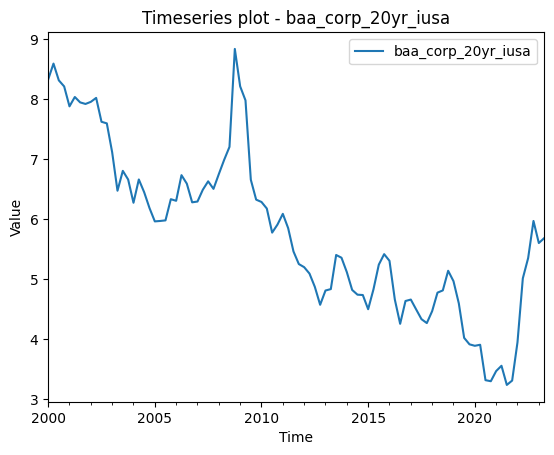

'25 .png files have been created in the sample_output/plots folder'

In [14]:
timeseries_plots.plot_all_ts(data=dataset, timestamp=None, variables = None, save_dir = "sample_output/plots")

# Variable transformations

Variable transformations are provided as a configuration table, where the user specifies the types of transformations and maximum lag to be used for each variable. 

This code will generate a template for you to fill in. This template will be placed in the 'variable_mapping_table' sheet of the Excel. 

If you already have a mapping table and want to use that, simply include your mapping table in the input Excel with the tab name 'variable_mapping_table'

In [15]:
# Set frequency of the data
data_frequency = 4  # 1 if annual, 4 if quarterly, and 12 if monthly

The following code creates a variable mapping table based on the data frequency indicated. Mannual selection/indication for DV/IV/Dummy, lags, and transformations are required in this mapping table to proceed.

In [16]:
# Create the variable_mapping_table
variable_mapping_table= timeseries_transforms.create_var_mapping_table(dataset.columns[1:],dataset.columns[1:],data_frequency=data_frequency)
variable_mapping_table.head(1)

,Variable Name,Standardized Name,Main Category,DV or IV or Dummy?,# lags,No Transform,Log Transform,QoQ Diff,QoQ Log Diff,QoQ % Change,...,YoY Log Diff,YoY % Change,YoY Abs Diff,YoY Ratio,Normalize,Normalize by ID,Normalize by Time,Demean by Time,Detrend,Deseasonalize
0,myDepVar,myDepVar,None,None,None,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Export to a new sheet of the session Excel file. This will automatically be skipped if you are loading a session that has a tab called 'variable_mapping_table'**

In [17]:
from openpyxl import load_workbook
wb = load_workbook(filename=used_filepath, read_only=True) 
sheet_names = list(wb.sheetnames)
wb.close()
if 'variable_mapping_table' not in sheet_names:

    # Export the table for manual transformation selection
    with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
        # Write the variable mapping table to a new sheet
        variable_mapping_table.to_excel(writer, sheet_name='variable_mapping_table', index=False)
else:
    print("Detected an existing mapping table, and so will not create a new blank template for variable mapping")

Detected an existing mapping table, and so will not create a new blank template for variable mapping


**If you created a new blank mapping table, you will need to go into the Excel and specify which transformations should be used.**

**Run the following code to accept the mapping table and perform the transformations**

In [18]:
# Read in transformations
transformations_input = pd.read_excel(used_filepath, sheet_name='variable_mapping_table')

# Transform dataset
dataset_transformed = timeseries_transforms.run_transforms(ts_data=dataset, transformations=transformations_input, frequency=data_frequency)

**Export to a new sheet of the session Excel file. Skip this if you are loading a previous session that already has this test results.**

In [19]:
# Output transformed dataset into excel
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the transformed dataset to a new sheet
    dataset_transformed['data'].to_excel(writer, sheet_name='transformed_dataset', index=True)

# Unit root / stationarity testing

In a regression where dependent and independent variables are stationary, the estimated relationship (if statistically significant) is reliable and not spurious. This is intuitive since each variable moves around a time-invariant mean in the long-run, and as long as the historical correlation between the variables persist, they will move together.

On the other hand, if the time-series are non-stationary, the relationship found by the regression could be spurious, as in the long run the variables can behave very differently.

Statistical tests for stationarity suffer from small sample size distortion and weak power. Choice of test and lag selection is important to get more accurate results, along with business intuition on the variable and its transformation. 

If variables are potentially non-stationary, cointegration can be assessed using stationarity tests on model residuals (with different critical values since the residuals are estimated model errors). 

**Tests covered**

We use the 'statsmodels.tsa.stattools' module for some of these unit root tests: 
- Augmented Dickey Fuller (ADF)
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

And use a custom sklearn-based implementation for DF-GLS, which is a more autocorrelation robust version of ADF.

statsmodels also provides Zivot-Andrews structural-break unit-root test and Range unit-root test for stationarity, which are not covered in this section (as they are less standard)

In [20]:
variables_to_test = [col for col in dataset_transformed['data'].columns if col.endswith("|L0")]

In [21]:
unit_root_testing_results=unit_root_testing.unit_root_test_wrapper(data=dataset_transformed['data'], 
                                         variables=variables_to_test, 
                                         tests=['ADF', 'KPSS', 'DF-GLS'], 
                                         maxlag=['Auto'], 
                                         type=['zero mean','mean'], 
                                         adf_lag_selection=["BIC", "Fixed"], 
                                         dfgls_lag_selection=['MAIC2'])

Working on Model #1 out of 92
Working on Model #11 out of 92
Working on Model #21 out of 92
Working on Model #31 out of 92
Working on Model #41 out of 92
Working on Model #51 out of 92
Working on Model #61 out of 92
Working on Model #71 out of 92
Working on Model #81 out of 92
Working on Model #91 out of 92


**Export to a new sheet of the session Excel file. Skip this if you are loading a previous session that already has this test results.**

In [22]:
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the unit_root_testing results to a new sheet
    unit_root_testing_results.to_excel(writer, sheet_name='unit_root_testing', index=False)

# Model settings

Specify training (and optional testing) dataset, dependent variable, forced in variables, and independent variables

In [23]:
cut_off_date= datetime(2019,12,31)

In [24]:
train_dataset, test_dataset = timeseries_transforms.train_test_split(dataset_transformed['data'], cut_off_date)

In [25]:
target_var= 'myDepVar|N|L0'

In [26]:
forced_in_vars = None
independent_variables = list(dataset_transformed["var_mapping"]["FullName"])
independent_variables = independent_variables[2:]

# SFA

Perform single factor analysis by using the function defined in the utilities folder.

In [27]:
SFA_results = sfa_ols.sfa_ols(dataset=train_dataset, 
                      DV=target_var, IVs=independent_variables, forced_in = forced_in_vars, 
                      intercept=True, 
                      robust="HC3", 
                      get_fitted=True)

Working on real_gdp_iusa|QPD|L0, which is #1 out of 270
Working on nom_gdp_iusa|YPD|L1, which is #11 out of 270
Working on bankrupt_totalbus_iusa|QPD|L2, which is #21 out of 270
Working on cap_index_iusa|QPD|L0, which is #31 out of 270
Working on pers_consumpdurables_iusa|YPD|L1, which is #41 out of 270
Working on cap_util_iusa|YA|L2, which is #51 out of 270
Working on high_bonds_iusa|N|L0, which is #61 out of 270
Working on high_bonds_iusa|YA|L1, which is #71 out of 270
Working on labor_force_participation_iusa|N|L2, which is #81 out of 270
Working on labor_force_participation_iusa|YD|L0, which is #91 out of 270
Working on baa_corp_20yr_iusa|QD|L1, which is #101 out of 270
Working on baa_corp_20yr_iusa|YD|L2, which is #111 out of 270
Working on bbb_corp_10yr_iusa|QPD|L0, which is #121 out of 270
Working on bbb_corp_10yr_iusa|YPD|L1, which is #131 out of 270
Working on fedfund_iusa|QPD|L2, which is #141 out of 270
Working on tbond_10yr_iusa|N|L0, which is #151 out of 270
Working on tbo

In [28]:
SFA_results['results']

,Variable,# Obs,# Miss,Intercept,Var Coef,Intercept p-val,Var p-val,Int HC3 p-val,Var HC3 p-val,Rsq,Adj Rsq,MSE,RMSE,AIC,BIC,Durbin-Waston,Var Std. Coef
0,real_gdp_iusa|QPD|L0,79.0,0.0,2.855019,3.749611,2.589893e-39,0.799496,1.788721e-25,9.998752e-01,0.000843,-0.012133,0.540695,0.735320,179.615182,184.354078,1.458304,0.029034
1,real_gdp_iusa|QPD|L1,78.0,0.0,2.695777,34.581786,4.058408e-38,0.017676,1.017487e-21,0.000000e+00,0.071828,0.059615,0.507759,0.712572,172.490020,177.203438,1.518281,0.268007
2,real_gdp_iusa|QPD|L2,77.0,0.0,2.684500,36.425334,1.205605e-37,0.013049,4.203804e-21,0.000000e+00,0.079384,0.067109,0.509131,0.713534,170.537730,175.225341,1.603505,0.281751
3,real_gdp_iusa|YPD|L0,76.0,0.0,2.558000,16.180242,1.359595e-30,0.003092,3.369459e-18,7.221425e-290,0.112252,0.100256,0.487048,0.697888,165.004835,169.666301,1.637840,0.335041
4,real_gdp_iusa|YPD|L1,75.0,0.0,2.471281,20.653312,2.310926e-30,0.000132,8.194114e-17,0.000000e+00,0.182539,0.171341,0.454459,0.674136,157.692235,162.327211,1.651830,0.427245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,unemploy_iusa|YD|L1,75.0,0.0,2.875218,-0.327823,1.688844e-49,0.000013,3.280103e-26,4.995886e-01,0.231063,0.220530,0.427482,0.653821,153.102598,157.737574,1.793872,-0.480691
266,unemploy_iusa|YD|L2,74.0,0.0,2.885965,-0.276682,9.572230e-48,0.000306,3.369324e-26,4.859115e-01,0.166645,0.155070,0.463700,0.680955,157.132600,161.740730,1.668107,-0.408221
267,unemploy_iusa|YPD|L0,76.0,0.0,2.899322,-1.765526,2.743493e-50,0.000022,5.901267e-27,8.999110e-01,0.217196,0.206617,0.429473,0.655342,155.443665,160.105131,1.733883,-0.466043
268,unemploy_iusa|YPD|L1,75.0,0.0,2.901663,-1.788484,1.509264e-49,0.000019,8.166922e-27,9.023607e-01,0.222476,0.211825,0.432256,0.657462,153.935516,158.570492,1.776418,-0.471674


**Export to a new sheet of the session Excel file. Skip this if you are loading a previous session that already has this test results.**

In [27]:
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the SFA results to a new sheet
    SFA_results['results'].to_excel(writer, sheet_name='SFA_results', index=False)

# MFA with variable selection

## Variable Short List

The goal is to create a shortlist of variables for in variable selection. We create a column called `Selection` in the output table, and use logic (or manual override) to set those to True or False depending on whether the variable should be selected. 

In [28]:
# Read in the SFA results from the Excel instead of using the dataframe from prior section
# (in case the user manually made a change in the results)
sfa_results = pd.read_excel(used_filepath, sheet_name='SFA_results')

**p-value filter**

In [29]:
# Add threshold for p-value filter
p_val_threshold= 0.05
sfa_results['Selection'] = sfa_results['Var p-val'] < p_val_threshold

**Other filters can be added**

Just make sure you chain the conditions, e.g.

`sfa_results['Selection'] = sfa_results['Selection'] & (sfa_results['Rsq'] < R2_threshold)`

**Save the changes into the Excel**

In [30]:
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    # Write the SFA results to a new sheet
    sfa_results.to_excel(writer, sheet_name='SFA_results', index=False)

**If you want to manually edit the selection, you can go into the "SFA_results" sheet in the Excel to adjust the selection of variables**

The variables that have 'Selection' == True will be used. 


In [31]:
# Load the short list of variables selected for MFA
var_selection = pd.read_excel(used_filepath, sheet_name='SFA_results')
var_selection_variables = var_selection.loc[var_selection['Selection'], 'Variable']

## Example of using best subsets in R for variable selection

This requires R 3.2 or later installed.

In [32]:
# Settings
max_var = 3
num_models = 100

In [33]:
# (Optional) Use the following 2 lines if you have multiple R versions and want to specify
# import os
# os.environ['R_HOME'] = 'C:/path.to.R/R-4.3.1' # file path to R installation

# Load rpy2 (install it if necessary)
try:
    %load_ext rpy2.ipython
except:
    print("Installing rpy2")
    !pip install rpy2
    %load_ext rpy2.ipython
    
print("Successfully loaded rpy2")

import rpy2
import rpy2.robjects as robjects

Successfully loaded rpy2


c:\users\daniel.wang\gryphon\regression\.venv\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [34]:
if forced_in_vars is None:
    Dummies = robjects.StrVector([])
else:
    Dummies = robjects.StrVector(forced_in_vars)
IV = robjects.StrVector(var_selection_variables)

In [35]:
%%R -i train_dataset -i max_var -i num_models -i target_var -i Dummies -i IV -i max_var -i num_models -o Store_variables -o Store_stats

if (!require(leaps)) {
    install.packages('leaps', repos = "https://cloud.r-project.org")
}

library(leaps)

subsets_data = na.omit(train_dataset[c(target_var, IV, Dummies)])
colnames(subsets_data)[1] = "Dep_local_var"

if (length(Dummies) == 0) {
    subsets = regsubsets(Dep_local_var~.,data=subsets_data,nbest=num_models,nvmax=max_var-1,really.big = TRUE, method = "exhaustive")
} else {
    subsets = regsubsets(Dep_local_var~.,data=subsets_data,force.in = seq(length(subsets_data[1,])-length(Dummies),length(subsets_data[1,])-1),nbest=num_models,nvmax=max_var + length(Dummies)-1,really.big = TRUE, method = "exhaustive")
}
subset_result = summary(subsets)

if (length(Dummies) == 0) {
    Check = sum(1*subset_result$which[length(subset_result$which[,1]),])-1
  } else {
    Check = sum(1*subset_result$which[length(subset_result$which[,1]),])-length(Dummies)-1
  }
  
  if (Check != max_var) {
    if (length(Dummies) == 0) {
      subsets = regsubsets(Dep_local_var~.,data=subsets_data,nbest=num_models,nvmax=max_var,really.big = TRUE, method = "exhaustive")
      subset_result = summary(subsets)
    } else {
      subsets = regsubsets(Dep_local_var~.,data=subsets_data,force.in = seq(length(subsets_data[1,])-length(Dummies),length(subsets_data[1,])-1),nbest=num_models,nvmax=max_var + length(Dummies),really.big = TRUE, method = "exhaustive")
      subset_result = summary(subsets)
    }
    if (length(Dummies) == 0) {
      Check = sum(1*subset_result$which[length(subset_result$which[,1]),])-1
    } else {
      Check = sum(1*subset_result$which[length(subset_result$which[,1]),])-length(Dummies)-1
    }
  }
  #If still not the right number of variables are found. Print error to the log
  if (Check != max_var) {
    print("Warning, best subsets did not find the right number of variables")
    break
  }
  
  # Extract the variables that were selected through best subsets
  if (length(Dummies) == 0) {
    Num_var = as.numeric(rownames(subset_result$which))
  } else {
    Num_var = as.numeric(rownames(subset_result$which))-length(Dummies)
  }
  
  # Declare variables that will be used to store the variable names
  Store_variables = matrix(nrow = length(Num_var),ncol = max_var)
  Var_index = Store_variables
  colnames(Store_variables) = paste("Var",seq(1,max_var), sep = "")
  Store_variables = as.data.frame(Store_variables, check.names = FALSE)
  
  # Initiate the variables that will be used to store the best subsets regression output (for debugging and comparing actual R2 with best subsets estimated R2)
  Store_stats = data.frame(rsq = rep(NA,length(Num_var)),
                           adj_rsq = rep(NA,length(Num_var)),
                           bic = rep(NA,length(Num_var)),stringsAsFactors = FALSE)
  
  Which = subset_result$which
  
  # Identify the variables selected through best subsets algorithm
  for (i in 1:length(Num_var)) {
    Variables = Which[i,]
    if (length(Dummies) == 0) {
      Variables = names(Variables)[Variables][-1]
      Variables = gsub('`','',Variables)
    } else {
      Variables = names(Variables)[Variables][-1]
      Variables = gsub('`','',Variables)
      Dummy_location = match(Dummies,Variables)
      Variables = Variables[-Dummy_location]
    }
    Store_variables[i,] = c(Variables,rep("NA",max_var-length(Variables)))
    Store_stats[i,] = c(subset_result$rsq[i], subset_result$adjr2[i], subset_result$bic[i])
  }

Reordering variables and trying again:


Loading required package: leaps
In addition: Warning messages:
1: package 'leaps' was built under R version 4.2.3 
2: In leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in,  :
  51  linear dependencies found


**Top models identified**

Top models with their approximate r-squared metrics. These are identified using the time-periods for which all variables have data.

In [36]:
top_model_list = pd.concat([Store_variables, Store_stats], axis=1).sort_values(by='rsq', ascending=False).reset_index(drop=True)
top_model_list.head()

,Var1,Var2,Var3,rsq,adj_rsq,bic
0,real_gdp_iusa|YPD|L0,indust_prod_iusa|YPD|L0,high_bonds_iusa|YA|L2,0.581285,0.558023,-34.250990
1,indust_prod_iusa|YPD|L0,bbb_corp_10yr_iusa|YD|L0,corporate_cash_flow_iusa|YPD|L1,0.580424,0.557114,-34.131838
2,indust_prod_iusa|YPD|L1,bbb_corp_10yr_iusa|YD|L0,corporate_cash_flow_iusa|YPD|L1,0.578908,0.555514,-33.922649
3,indust_prod_iusa|YPD|L0,high_bonds_iusa|YA|L2,fedfund_iusa|YD|L1,0.576535,0.553009,-33.596763
4,indust_prod_iusa|YPD|L0,high_bonds_iusa|YA|L0,high_bonds_iusa|YA|L2,0.572569,0.548823,-33.056108


In [37]:
subsets_model_list = top_model_list[[col for col in top_model_list.columns if col.startswith("Var")]].copy()
subsets_model_list.head()

,Var1,Var2,Var3
0,real_gdp_iusa|YPD|L0,indust_prod_iusa|YPD|L0,high_bonds_iusa|YA|L2
1,indust_prod_iusa|YPD|L0,bbb_corp_10yr_iusa|YD|L0,corporate_cash_flow_iusa|YPD|L1
2,indust_prod_iusa|YPD|L1,bbb_corp_10yr_iusa|YD|L0,corporate_cash_flow_iusa|YPD|L1
3,indust_prod_iusa|YPD|L0,high_bonds_iusa|YA|L2,fedfund_iusa|YD|L1
4,indust_prod_iusa|YPD|L0,high_bonds_iusa|YA|L0,high_bonds_iusa|YA|L2


## Alternative variable selection through all relevant combinations of models

Start with 2 variable models, and then force in top 2-variable combinations to find incremental variables.

### Two-variable models

In [38]:
# Use the short list for variables to create different combinations for 2 variable models
two_vars = mfa_ols.find_combinations(var_selection_variables,2, max_per_variable=1)
two_vars

,Var1,Var2
0,real_gdp_iusa|QPD|L2,None
1,real_gdp_iusa|YPD|L0,None
2,real_gdp_iusa|YPD|L1,None
3,real_gdp_iusa|YPD|L2,None
4,nom_gdp_iusa|QPD|L1,None
...,...,...
5161,corp_profit_iva_iusa|YPD|L0,unemploy_iusa|YD|L1
5162,corp_profit_iva_iusa|YPD|L0,unemploy_iusa|YD|L2
5163,corp_profit_iva_iusa|YPD|L0,unemploy_iusa|YPD|L0
5164,corp_profit_iva_iusa|YPD|L0,unemploy_iusa|YPD|L1


In [39]:
# Perform MFA runs
two_variable_vars = mfa_ols.mfa_ols_wrapper(
    dataset=train_dataset,
    oos_dataset=test_dataset,
    DV=target_var, 
    IV_table = two_vars,
    intercept = True,
    robust="HC3",
    get_fitted=False,
    timeseries=True,
    test_options=mfa_ols.default_options_ols)

Working on Model #1 out of 5166
Working on Model #11 out of 5166
Working on Model #21 out of 5166
Working on Model #31 out of 5166
Working on Model #41 out of 5166
Working on Model #51 out of 5166
Working on Model #61 out of 5166
Working on Model #71 out of 5166
Working on Model #81 out of 5166
Working on Model #91 out of 5166
Working on Model #101 out of 5166
Working on Model #111 out of 5166
Working on Model #121 out of 5166
Working on Model #131 out of 5166
Working on Model #141 out of 5166
Working on Model #151 out of 5166
Working on Model #161 out of 5166
Working on Model #171 out of 5166
Working on Model #181 out of 5166
Working on Model #191 out of 5166
Working on Model #201 out of 5166
Working on Model #211 out of 5166
Working on Model #221 out of 5166
Working on Model #231 out of 5166
Working on Model #241 out of 5166
Working on Model #251 out of 5166
Working on Model #261 out of 5166
Working on Model #271 out of 5166
Working on Model #281 out of 5166
Working on Model #291 out

Working on Model #2381 out of 5166
Working on Model #2391 out of 5166
Working on Model #2401 out of 5166
Working on Model #2411 out of 5166
Working on Model #2421 out of 5166
Working on Model #2431 out of 5166
Working on Model #2441 out of 5166
Working on Model #2451 out of 5166
Working on Model #2461 out of 5166
Working on Model #2471 out of 5166
Working on Model #2481 out of 5166
Working on Model #2491 out of 5166
Working on Model #2501 out of 5166
Working on Model #2511 out of 5166
Working on Model #2521 out of 5166
Working on Model #2531 out of 5166
Working on Model #2541 out of 5166
Working on Model #2551 out of 5166
Working on Model #2561 out of 5166
Working on Model #2571 out of 5166
Working on Model #2581 out of 5166
Working on Model #2591 out of 5166
Working on Model #2601 out of 5166
Working on Model #2611 out of 5166
Working on Model #2621 out of 5166
Working on Model #2631 out of 5166
Working on Model #2641 out of 5166
Working on Model #2651 out of 5166
Working on Model #26

Working on Model #4731 out of 5166
Working on Model #4741 out of 5166
Working on Model #4751 out of 5166
Working on Model #4761 out of 5166
Working on Model #4771 out of 5166
Working on Model #4781 out of 5166
Working on Model #4791 out of 5166
Working on Model #4801 out of 5166
Working on Model #4811 out of 5166
Working on Model #4821 out of 5166
Working on Model #4831 out of 5166
Working on Model #4841 out of 5166
Working on Model #4851 out of 5166
Working on Model #4861 out of 5166
Working on Model #4871 out of 5166
Working on Model #4881 out of 5166
Working on Model #4891 out of 5166
Working on Model #4901 out of 5166
Working on Model #4911 out of 5166
Working on Model #4921 out of 5166
Working on Model #4931 out of 5166
Working on Model #4941 out of 5166
Working on Model #4951 out of 5166
Working on Model #4961 out of 5166
Working on Model #4971 out of 5166
Working on Model #4981 out of 5166
Working on Model #4991 out of 5166
Working on Model #5001 out of 5166
Working on Model #50

**Export to a new sheet of the session Excel file. Skip this if you are loading a previous session that already has this test results.**

In [40]:
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the data to a new sheet
    two_variable_vars['results'].sort_values(by='Rsq', ascending=False).to_excel(writer, sheet_name='top_models_2_var', index=False)

### Short list top 2 variable models, for which to search for incremental variable



In [41]:
# Create a list for 2 variable models filtering
model_short_list= two_variable_vars['results'].sort_values(by='Rsq', ascending=False).loc[:, ["Var 1", "Var 2", "Rsq"]]
model_short_list['Selected']= False

# Export the list
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the data to a new sheet
    model_short_list.to_excel(writer, sheet_name='selected_models_2_var', index=False)

**Go to "selected_models_2_var" sheet to manually select models.**

In this example, models are manually selected in a random way for illustration purpose.

In [42]:
# Read in model short list
selected_starting_models = pd.read_excel(used_filepath, sheet_name='selected_models_2_var')
selected_starting_models = selected_starting_models.loc[selected_starting_models['Selected']==True].reset_index(drop=True)[['Var 1', "Var 2"]]

In [43]:
selected_starting_models

,Var 1,Var 2
0,retail_sales_tot_iusa|YPD|L2,corporate_cash_flow_iusa|YPD|L1
1,indust_prod_iusa|YPD|L1,bbb_corp_10yr_iusa|YD|L0
2,high_bonds_iusa|QPD|L0,retail_sales_tot_iusa|YPD|L2
3,libor_3m_iusa|YD|L0,retail_sales_tot_iusa|YPD|L2
4,indust_prod_iusa|YPD|L0,bbb_corp_10yr_iusa|YD|L0
5,cap_index_iusa|YPD|L2,retail_sales_tot_iusa|YPD|L2
6,high_bonds_iusa|QD|L0,retail_sales_tot_iusa|YPD|L2


### Generate all incremental variables

In [44]:
three_vars = mfa_ols.find_incremental(selected_starting_models, var_selection_variables)
three_vars

,Var1,Var2,Var3
0,real_gdp_iusa|QPD|L2,retail_sales_tot_iusa|YPD|L2,corporate_cash_flow_iusa|YPD|L1
1,real_gdp_iusa|QPD|L2,indust_prod_iusa|YPD|L1,bbb_corp_10yr_iusa|YD|L0
2,real_gdp_iusa|QPD|L2,high_bonds_iusa|QPD|L0,retail_sales_tot_iusa|YPD|L2
3,real_gdp_iusa|QPD|L2,libor_3m_iusa|YD|L0,retail_sales_tot_iusa|YPD|L2
4,real_gdp_iusa|QPD|L2,indust_prod_iusa|YPD|L0,bbb_corp_10yr_iusa|YD|L0
...,...,...,...
709,unemploy_iusa|YPD|L2,high_bonds_iusa|QPD|L0,retail_sales_tot_iusa|YPD|L2
710,unemploy_iusa|YPD|L2,libor_3m_iusa|YD|L0,retail_sales_tot_iusa|YPD|L2
711,unemploy_iusa|YPD|L2,indust_prod_iusa|YPD|L0,bbb_corp_10yr_iusa|YD|L0
712,unemploy_iusa|YPD|L2,cap_index_iusa|YPD|L2,retail_sales_tot_iusa|YPD|L2


## Perform MFA regression on long candidate model list

### List from best subsets

In [45]:
MFA_results = mfa_ols.mfa_ols_wrapper(
    dataset=train_dataset, 
    oos_dataset=test_dataset,
    DV=target_var, 
    IV_table = subsets_model_list,
    intercept = True,
    robust="HC3",
    get_fitted=True,
    timeseries=True,
    test_options=mfa_ols.default_options_ols)

Working on Model #1 out of 300
Working on Model #11 out of 300
Working on Model #21 out of 300
Working on Model #31 out of 300
Working on Model #41 out of 300
Working on Model #51 out of 300
Working on Model #61 out of 300
Working on Model #71 out of 300
Working on Model #81 out of 300
Working on Model #91 out of 300
Working on Model #101 out of 300
Working on Model #111 out of 300
Working on Model #121 out of 300
Working on Model #131 out of 300
Working on Model #141 out of 300
Working on Model #151 out of 300
Working on Model #161 out of 300
Working on Model #171 out of 300
Working on Model #181 out of 300
Working on Model #191 out of 300
Working on Model #201 out of 300
Working on Model #211 out of 300
Working on Model #221 out of 300
Working on Model #231 out of 300
Working on Model #241 out of 300
Working on Model #251 out of 300
Working on Model #261 out of 300
Working on Model #271 out of 300
Working on Model #281 out of 300
Working on Model #291 out of 300


**Export to a new sheet of the session Excel file. Skip this if you are loading a previous session that already has this test results.**

In [46]:
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the MFA results to a new sheet
    MFA_results['results'].to_excel(writer, sheet_name='MFA_results', index=False)
    
    # Export the fitted values if needed -- only if you don't have a lot of models
    # MFA_results['fitted'].to_excel(writer, sheet_name='MFA_fitted', index=False)

### Manual list

In [47]:
MFA_results_manual = mfa_ols.mfa_ols_wrapper(
    dataset=train_dataset, 
    oos_dataset=test_dataset,
    DV=target_var, 
    IV_table = three_vars,
    intercept = True,
    robust="HC3",
    get_fitted=True,
    timeseries=True,
    test_options=mfa_ols.default_options_ols)

Working on Model #1 out of 714
Working on Model #11 out of 714
Working on Model #21 out of 714
Working on Model #31 out of 714
Working on Model #41 out of 714
Working on Model #51 out of 714
Working on Model #61 out of 714
Working on Model #71 out of 714
Working on Model #81 out of 714
Working on Model #91 out of 714
Working on Model #101 out of 714
Working on Model #111 out of 714
Working on Model #121 out of 714
Working on Model #131 out of 714
Working on Model #141 out of 714
Working on Model #151 out of 714
Working on Model #161 out of 714
Working on Model #171 out of 714
Working on Model #181 out of 714
Working on Model #191 out of 714
Working on Model #201 out of 714
Working on Model #211 out of 714
Working on Model #221 out of 714
Working on Model #231 out of 714
Working on Model #241 out of 714
Working on Model #251 out of 714
Working on Model #261 out of 714
Working on Model #271 out of 714
Working on Model #281 out of 714
Working on Model #291 out of 714
Working on Model #301

**Export to a new sheet of the session Excel file. Skip this if you are loading a previous session that already has this test results.**

In [48]:
with pd.ExcelWriter(used_filepath, engine='openpyxl', mode='a') as writer:
    # Write the MFA results to a new sheet
    MFA_results_manual['results'].to_excel(writer, sheet_name='MFA_results_manual', index=False)
    
    # Export the fitted values if needed -- only if you don't have a lot of models
    # MFA_results_manual['fitted'].to_excel(writer, sheet_name='MFA_fitted_manual', index=False)

# Notes

R and Python (statsmodels)'s calculation of AIC and BIC are different: https://stackoverflow.com/questions/64531074/why-do-statsmodels-and-r-disagree-on-aic-computation (but it does not affect usage) 